In [135]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from scipy import stats


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier

In [102]:
loan_data = pd.read_csv("./data/lending_club_loan_two.csv")

In [103]:
print(loan_data.shape)
loan_data.head()

(396030, 27)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [104]:
loan_data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [105]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

# EDA

In [106]:
pd.DataFrame({'Count': loan_data['loan_status'].value_counts(),
                       'Percentage': loan_data['loan_status'].value_counts(normalize=True)*100})

,Count,Percentage
loan_status,,
Fully Paid,318357,80.387092
Charged Off,77673,19.612908


Around 80% of the loans are fully paid, with 20% charged off. This is a relatively imbalanced dataset for classification model training.

In [107]:
float_columns = loan_data.select_dtypes(include='float64')

<AxesSubplot:>

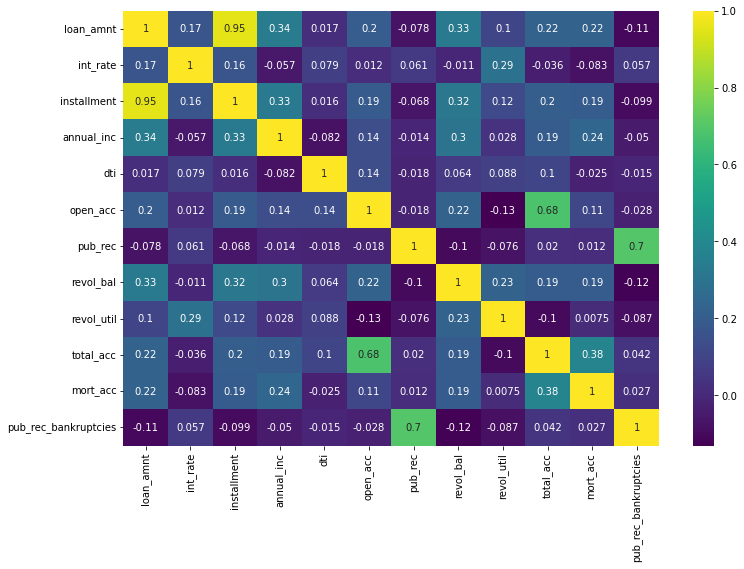

In [108]:
plt.figure(figsize=(12, 8))
sns.heatmap(float_columns.corr(), annot=True, cmap='viridis')

There is a strong correlation between the `loan_amount` and `installment` columns. This is a good opportunity for feature reduction.

# Data Cleaning

In [109]:
loan_data.isna().sum().sort_values(ascending=False)

mort_acc                37795
emp_title               22927
emp_length              18301
title                    1756
pub_rec_bankruptcies      535
revol_util                276
loan_amnt                   0
dti                         0
application_type            0
initial_list_status         0
total_acc                   0
revol_bal                   0
pub_rec                     0
open_acc                    0
earliest_cr_line            0
purpose                     0
term                        0
loan_status                 0
issue_d                     0
verification_status         0
annual_inc                  0
home_ownership              0
sub_grade                   0
grade                       0
installment                 0
int_rate                    0
address                     0
dtype: int64

Perform some simple data cleaning steps:
1. Dropping `emp_length`, `emp_title`, and `title` due to low association with output variable.   
2. Fill in missingness in `mort_acc` using averaged values from `total_acc`, which has the highest correlation.
3. Drop the rest of the rows with `NA` values.

In [110]:
loan_data = loan_data.drop(columns = ['emp_length', 'emp_title', 'title'] )

In [111]:
total_acc_avg = float_columns.groupby('total_acc').mean()['mort_acc']

In [112]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc
loan_data['mort_acc'] = loan_data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [113]:
loan_data = loan_data.dropna()

In [114]:
print(loan_data.shape)

(395219, 24)


# Prep Variables

In [115]:
term_values = {' 36 months': 36, ' 60 months': 60}
loan_data['term'] = loan_data['term'].map(term_values)

In [116]:
loan_data = loan_data.drop(columns=['grade'])

In [117]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
loan_data = pd.get_dummies(loan_data, columns=dummies, drop_first=True)



In [118]:
loan_data['zip_code'] = loan_data['address'].apply(lambda x: x[-5:])
loan_data = loan_data.drop(columns=['address'])

In [119]:
loan_data = pd.get_dummies(loan_data, columns=['zip_code'], drop_first=True)

In [120]:
loan_data = loan_data.drop(columns=['issue_d'])

In [121]:
loan_data['earliest_cr_line'] = pd.to_datetime(loan_data['earliest_cr_line']).dt.year

/tmp/ipykernel_5928/4150581994.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  loan_data['earliest_cr_line'] = pd.to_datetime(loan_data['earliest_cr_line']).dt.year


In [122]:
loan_data['loan_status'].value_counts()

loan_status
Fully Paid     317696
Charged Off     77523
Name: count, dtype: int64

In [123]:
loan_status_values = {'Fully Paid': 0, 'Charged Off': 1}
loan_data['loan_status'] = loan_data['loan_status'].apply(
    lambda x: loan_status_values[x.strip()])

# Model Training

In [124]:
train, test = train_test_split(loan_data, test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)


(264796, 81)
(130423, 81)


In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264796 entries, 43729 to 122200
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            264796 non-null  float64
 1   term                                 264796 non-null  int64  
 2   int_rate                             264796 non-null  float64
 3   installment                          264796 non-null  float64
 4   annual_inc                           264796 non-null  float64
 5   loan_status                          264796 non-null  int64  
 6   dti                                  264796 non-null  float64
 7   earliest_cr_line                     264796 non-null  int32  
 8   open_acc                             264796 non-null  float64
 9   pub_rec                              264796 non-null  float64
 10  revol_bal                            264796 non-null  float64
 11  revol_util    

In [126]:
X_train, y_train = train.drop(columns=['loan_status']), train.loan_status
X_test, y_test = test.drop(columns=['loan_status']), test.loan_status

In [127]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [128]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [136]:
clf = RandomForestClassifier(random_state=42)

In [137]:
# param_distributions = {
#     'clf__n_estimators': [100, 200, 300],
#     'clf__max_depth': [10, 20, 30, None],
#     'clf__min_samples_split': [2, 5, 10],
#     'clf__min_samples_leaf': [1, 2, 4],
#     'clf__class_weight': ['balanced', 'balanced_subsample', None]
# }
# Define custom scoring metrics
# scoring = {
#     'f1': make_scorer(f1_score),
#     'precision': make_scorer(precision_score),
#     'recall': make_scorer(recall_score),
#     'roc_auc': make_scorer(roc_auc_score)
# }

# # Initialize RandomizedSearchCV with StratifiedKFold
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# search = RandomizedSearchCV(
#     pipeline,
#     param_distributions=param_distributions,
#     n_iter=50,  # number of parameter settings sampled
#     scoring=scoring,
#     refit='f1',  # optimize for F1 score
#     cv=cv,
#     random_state=42,
#     n_jobs=-1,  # use all available cores
#     verbose=2,
#     return_train_score=True
# )
# Fit the model
# search.fit(X, y)

# # Print best parameters and scores
# print("\nBest parameters:", search.best_params_)
# print("\nBest cross-validation scores:")
# for metric in scoring.keys():
#     print(f"{metric}: {search.cv_results_[f'mean_test_{metric}'][search.best_index_]:.3f}")
    

In [138]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [140]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [143]:
pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.999991,1.000000,0.999992,0.999995,0.999992
recall,1.000000,0.999962,0.999992,0.999981,0.999992
f1-score,0.999995,0.999981,0.999992,0.999988,0.999992
support,212753.000000,52043.000000,0.999992,264796.000000,264796.000000


In [144]:
pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.881725,0.962388,0.889092,0.922056,0.897484
recall,0.995731,0.449882,0.889092,0.722807,0.889092
f1-score,0.935267,0.613142,0.889092,0.774204,0.872335
support,104943.000000,25480.000000,0.889092,130423.000000,130423.000000


In [146]:
import pickle
filename = 'rf_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

Modeling notes:
- `emp_title` - could do categorization? or some kind of cleaning
- `emp_length`- convert to int. standardize
- `homeownership` - convert to category
- `annual_income` - some outliers. standardize and remove outliers?
- `verified_income` ?
- 


In [7]:
loan_data['emp_title'].value_counts().head(10)

emp_title
manager             218
owner               204
teacher             201
driver              123
sales                97
registered nurse     88
rn                   80
supervisor           79
truck driver         63
office manager       61
Name: count, dtype: int64

<AxesSubplot:>

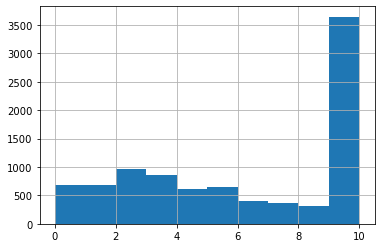

In [8]:
loan_data['emp_length'].hist()

In [9]:
loan_data['emp_length'].describe()

count    9183.000000
mean        5.930306
std         3.703734
min         0.000000
25%         2.000000
50%         6.000000
75%        10.000000
max        10.000000
Name: emp_length, dtype: float64

In [10]:
loan_data['homeownership'].value_counts()

homeownership
MORTGAGE    4789
RENT        3858
OWN         1353
Name: count, dtype: int64

array([[<AxesSubplot:title={'center':'annual_income'}>]], dtype=object)

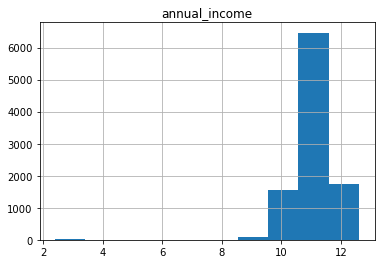

In [30]:
pd.DataFrame(np.log1p(loan_data[loan_data['annual_income']<3e5]['annual_income']+10)).hist()

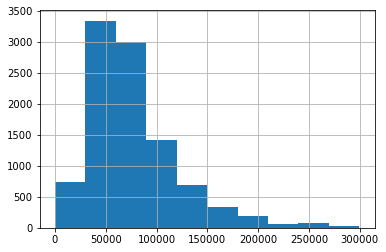

In [12]:
loan_data[loan_data['annual_income']<3e5]['annual_income'].hist();

In [28]:
loan_data['annual_income'].describe()

count    1.000000e+04
mean     7.922215e+04
std      6.473429e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.500000e+04
max      2.300000e+06
Name: annual_income, dtype: float64

In [36]:
loan_data['annual_income'].quantile(0.01)

13163.76

In [17]:
loan_data['verified_income'].value_counts()

verified_income
Source Verified    4116
Not Verified       3594
Verified           2290
Name: count, dtype: int64

In [19]:
loan_data['loan_status'].value_counts()

loan_status
Current               9375
Fully Paid             447
In Grace Period         67
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: count, dtype: int64

<AxesSubplot:>

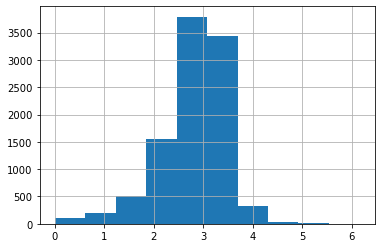

In [36]:
np.log1p(loan_data['debt_to_income']).hist()

<AxesSubplot:>

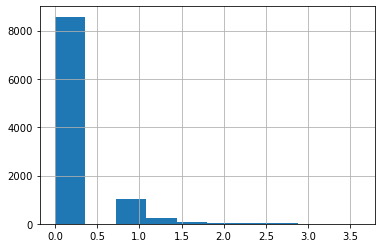

In [16]:
np.sqrt(loan_data['delinq_2y']).hist()

<AxesSubplot:>

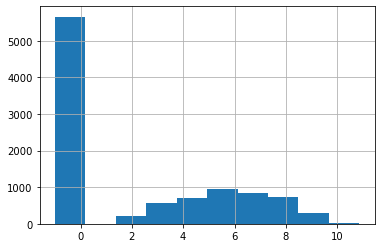

In [24]:
loan_data['months_since_last_delinq'].hist()

<AxesSubplot:>

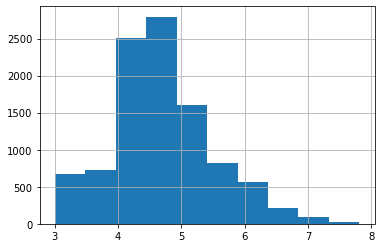

In [28]:
np.log1p(2024 - loan_data['earliest_credit_line']).hist()

In [42]:
results = {}
pt = PowerTransformer(method='yeo-johnson')
transformed = pt.fit_transform(loan_data['inquiries_last_12m'].to_numpy().reshape(-1, 1)).ravel()
results['yeo-johnson'] = transformed
results['yeo-johnson_transformer'] = pt

<AxesSubplot:>

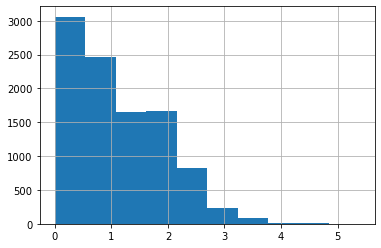

In [37]:
np.sqrt(loan_data['inquiries_last_12m']).hist()

<AxesSubplot:>

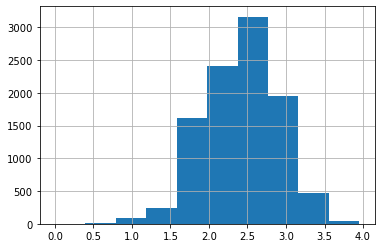

In [52]:
np.log1p(loan_data['open_credit_lines']).hist()

<AxesSubplot:>

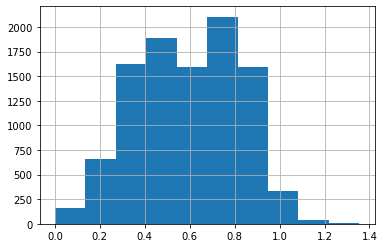

In [57]:
np.sqrt((loan_data['total_credit_utilized'].div(loan_data['total_credit_limit']))).hist()

<AxesSubplot:>

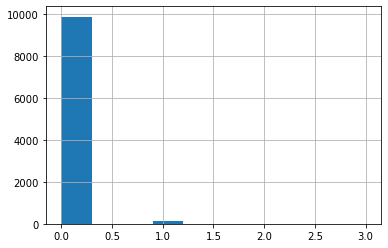

In [61]:
loan_data['num_collections_last_12m'].hist()

In [63]:
loan_data['num_historical_failed_to_pay'].describe()

count    10000.000000
mean         0.167100
std          0.687768
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         52.000000
Name: num_historical_failed_to_pay, dtype: float64

In [64]:
loan_data['num_historical_failed_to_pay'].value_counts()

num_historical_failed_to_pay
0     8586
1     1288
2       78
3       27
4       12
5        4
7        2
6        2
52       1
Name: count, dtype: int64

<AxesSubplot:>

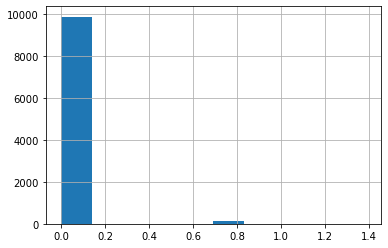

In [67]:
np.log1p(loan_data['num_collections_last_12m']).hist()

In [53]:
loan_data.iloc[:, 15:20].head()

,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late
0,70795,38767,0,0,38.0
1,28800,4321,0,1,NaN
2,24193,16000,0,0,28.0
3,25400,4997,0,1,NaN
4,69839,52722,0,0,NaN


Modeling notes:
- `emp_title` - could do categorization? or some kind of cleaning
- `emp_length`- fillNA with 0. convert to int. [DONE]
- `homeownership` - convert to category [DONE]
- `annual_income` - some outliers. standardize and remove outliers? [DONE]
- `verified_income` ?
- `debt_to_income` - normalize [DONE]
- `delinq_2y` - normalize [DONE]
- `months_since_last_delinq` - add missing indicator column, normalize, then fill NaNs with -1 [DONE]
- `earliest_credit_line` - subtract from 2024 and normalize [DONE]
- `inquiries_last_12m` - normalize [DONE]
- `total_credit_lines` - normalize [DONE]
- `open_credit_lines` - normalize [DONE]
- `total_credit_utilized`/`total_credit_limit` - combine into rate and normalize [DONE]
- `num_historical_failed_to_pay` - normalize [DONE]
- `num_collections_last_12m` - normalize [DONE]



- define 'default' as `loan_status`='Late (31-120 days)' or 'Late (16-30 days)' or 'Charged Off'


# Data Cleaning

In [103]:
loan_data['unemployed'] = loan_data['emp_length'].isna().astype(int)
loan_data['emp_length'] = loan_data['emp_length'].fillna(0).astype(int)

In [104]:
loan_data['debt_to_income'] = np.log1p(loan_data['debt_to_income'])
loan_data['debt_to_income'] = loan_data['debt_to_income'].fillna(-1.0)

In [105]:
loan_data['annual_income'] = loan_data['annual_income'].apply(lambda x: 3e5 if x>3e5 else x+10)
loan_data['annual_income'] = np.log1p(loan_data['annual_income'])

In [106]:
loan_data = pd.concat([loan_data.drop(columns=['homeownership']), pd.get_dummies(loan_data['homeownership'], drop_first=True)], axis=1)

In [107]:
loan_data['delinq_2y'] = np.sqrt(loan_data['delinq_2y'])

In [108]:
loan_data['no_delinquency'] = loan_data['months_since_last_delinq'].isna().astype(int)
loan_data['months_since_last_delinq'] = np.sqrt(loan_data['months_since_last_delinq']).fillna(-1)

In [109]:
loan_data['age_of_credit_history'] = np.log1p(2024 - loan_data['earliest_credit_line'])

In [110]:
loan_data['inquiries_last_12m'] = np.sqrt(loan_data['inquiries_last_12m'])

In [111]:
loan_data['total_credit_lines'] = np.log1p(loan_data['total_credit_lines'])

In [112]:
loan_data['open_credit_lines'] = np.log1p(loan_data['open_credit_lines'])

In [113]:
loan_data['credit_utilization_rate'] = np.sqrt((loan_data['total_credit_utilized'].div(loan_data['total_credit_limit'])))
loan_data['credit_utilization_rate'] = loan_data['credit_utilization_rate'].fillna(-1)

In [114]:
loan_data['num_collections_last_12m'] = np.log1p(loan_data['num_collections_last_12m'])

In [115]:
loan_data['num_historical_failed_to_pay'] = np.log1p(loan_data['num_historical_failed_to_pay'])

In [116]:
loan_data['default'] = loan_data['loan_status'].apply(lambda x: int(x in ['Late (16-30 days)', 'Late (31-120 days)', 'Charged Off']))
print(loan_data['default'].value_counts())

default
0    9889
1     111
Name: count, dtype: int64


# ML Modeling

- aggregate input columns [DONE]
- check for NaN values [DONE]
- check data types [DONE]

In [117]:
loan_data.columns

Index(['emp_title', 'emp_length', 'state', 'annual_income', 'verified_income',
       'debt_to_income', 'annual_income_joint', 'verification_income_joint',
       'debt_to_income_joint', 'delinq_2y', 'months_since_last_delinq',
       'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines',
       'open_credit_lines', 'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m', 'num_historical_failed_to_pay',
       'months_since_90d_late', 'current_accounts_delinq',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_satisfactory_accounts', 'num_accounts_120d_past_due',
       'num_accounts_30d_past_due', 'num_active_debit_accounts',
       'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt',
       'loan_purpo

In [124]:
input_columns = [
    'emp_length',
    'debt_to_income',
    'annual_income',
    'OWN',
    'RENT',
    'delinq_2y',
    'no_delinquency',
    'months_since_last_delinq',
    'age_of_credit_history',
    'credit_utilization_rate',
    'inquiries_last_12m',
    'total_credit_lines',
    'open_credit_lines',
    'num_historical_failed_to_pay',
    'num_collections_last_12m'
]

target_column = ['default']
    

In [126]:
clean_loan_data = loan_data[input_columns+target_column]
print(clean_loan_data.isna().sum())

emp_length                      0
debt_to_income                  0
annual_income                   0
OWN                             0
RENT                            0
delinq_2y                       0
no_delinquency                  0
months_since_last_delinq        0
age_of_credit_history           0
credit_utilization_rate         0
inquiries_last_12m              0
total_credit_lines              0
open_credit_lines               0
num_historical_failed_to_pay    0
num_collections_last_12m        0
default                         0
dtype: int64


In [129]:
clean_loan_data.dtypes

emp_length                        int64
debt_to_income                  float64
annual_income                   float64
OWN                                bool
RENT                               bool
delinq_2y                       float64
no_delinquency                    int64
months_since_last_delinq        float64
age_of_credit_history           float64
credit_utilization_rate         float64
inquiries_last_12m              float64
total_credit_lines              float64
open_credit_lines               float64
num_historical_failed_to_pay    float64
num_collections_last_12m        float64
default                           int64
dtype: object

In [132]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import StratifiedKFold

In [149]:
def create_imbalanced_classifier(X, y):
    """
    Creates a robust classification pipeline with cross-validation for highly imbalanced data
    
    Parameters:
    X: feature matrix
    y: target vector
    
    Returns:
    best_model: fitted pipeline with best parameters
    cv_results: detailed cross-validation results
    """
    
    # Create pipeline with SMOTE and classifier
    pipeline = ImbPipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ])
    
    # Define parameter space
    param_distributions = {
#         'sampler__sampling_strategy': [0.01, 0.3, 0.5, 0.7],  # ratio of minority to majority class
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [10, 20, 30, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__class_weight': ['balanced', 'balanced_subsample', None]
    }
    
    # Define custom scoring metrics
    scoring = {
        'f1': make_scorer(f1_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'roc_auc': make_scorer(roc_auc_score)
    }
    
    # Initialize RandomizedSearchCV with StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=50,  # number of parameter settings sampled
        scoring=scoring,
        refit='f1',  # optimize for F1 score
        cv=cv,
        random_state=42,
        n_jobs=-1,  # use all available cores
        verbose=2,
        return_train_score=True
    )
    
    # Fit the model
    search.fit(X, y)
    
    # Print best parameters and scores
    print("\nBest parameters:", search.best_params_)
    print("\nBest cross-validation scores:")
    for metric in scoring.keys():
        print(f"{metric}: {search.cv_results_[f'mean_test_{metric}'][search.best_index_]:.3f}")
    
    return search

In [154]:
X=clean_loan_data.drop(columns=target_column).to_numpy()
y=clean_loan_data[target_column].to_numpy().ravel()

In [155]:
grid_search = create_imbalanced_classifier(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=100; total time=   1.1s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=100; total time=   1.0s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.1s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.0s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   0.9s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=20, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   3.1s
[CV] END clf__class_weight=balanced_subsampl

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=100; total time=   1.1s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=100; total time=   0.9s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=100; total time=   1.1s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.0s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   0.9s
[CV] END clf__class_weight=balanced_subsample, clf__max_depth=20, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   3.2s
[CV] END clf__class_weight=balanced_subsamp

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

[CV] END clf__class_weight=None, clf__max_depth=None, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=200; total time=   1.9s
[CV] END clf__class_weight=None, clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.9s
[CV] END clf__class_weight=None, clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.8s
[CV] END clf__class_weight=None, clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   3.2s
[CV] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.6s
[CV] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.7s
[CV] END clf__class_weight=balanced, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_est

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

[CV] END clf__class_weight=None, clf__max_depth=30, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.7s
[CV] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.8s
[CV] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.7s
[CV] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.6s
[CV] END clf__class_weight=balanced, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.8s
[CV] END clf__class_weight=balanced, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.7s
[CV] END clf__class_weight=balanced, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/anaconda3/lib/p


Best parameters: {'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_depth': 10, 'clf__class_weight': 'balanced_subsample'}

Best cross-validation scores:
f1: 0.000
precision: 0.000
recall: 0.000
roc_auc: 0.500
[CV] END clf__class_weight=None, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=200; total time=   2.0s
[CV] END clf__class_weight=None, clf__max_depth=20, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100; total time=   0.9s
[CV] END clf__class_weight=None, clf__max_depth=20, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100; total time=   1.0s
[CV] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100; total time=   0.9s
[CV] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100; total time=   0.9s
[CV] EN

In [156]:
grid_search

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('clf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__class_weight': ['balanced',
                                                              'balanced_subsample',
                                                              None],
                                        'clf__max_depth': [10, 20, 30, None],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5,...
                                        'clf__n_estimators': [100, 200, 300]},
                   random_state=42, refit='f1', return_train_score=True,
                   scoring={'f1': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method='predict')},
                   verbose=2)